# import libraries

In [ ]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/NSU/Fake_med/archive (1) 2.zip'

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/NSU/Fake_med/Dataset1', output="splitted_data", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 4200 files [01:26, 48.62 files/s] 


In [ ]:
!zip -r '/content/splitted_data.zip' '/content/splitted_data'

!cp '/content/splitted_data.zip' -d '/content/drive/MyDrive/NSU/Fake_med'

  adding: content/splitted_data/ (stored 0%)
  adding: content/splitted_data/train/ (stored 0%)
  adding: content/splitted_data/train/Real/ (stored 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-621.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-93.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-486.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-650.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-505.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-434.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-261.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-641.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-107.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-521.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-238.png (defl

In [ ]:
!cp '/content/drive/MyDrive/NSU/Fake_med/splitted_data.zip' -d '/content'
!unzip '/content/splitted_data.zip'

Archive:  /content/splitted_data.zip
   creating: content/splitted_data/
   creating: content/splitted_data/train/
   creating: content/splitted_data/train/Real/
  inflating: content/splitted_data/train/Real/Tuberculosis-621.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-93.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-486.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-650.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-505.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-434.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-261.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-641.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-107.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-521.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-238.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-649.png  
  inflating

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preprocessing

#### we will split the data by the generator to train,test and validation.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Set the directories for training, validation, and test data
train_dir = '/content/splitted_data/train'
validation_dir = '/content/splitted_data/val'
test_dir = '/content/splitted_data/test'

the usage of data augmentation techniques using the ImageDataGenerator class from the tensorflow.keras.preprocessing.image module.

train_datagen is an instance of ImageDataGenerator used for data augmentation during training. It applies various transformations to the input images to generate augmented samples. The transformations include:

rotation_range: Randomly rotates the image within the specified range (in degrees).
width_shift_range and height_shift_range: Randomly shifts the image horizontally and vertically within the specified range (as a fraction of total width or height).
shear_range: Applies shearing transformation to the image within the specified range.
zoom_range: Randomly zooms the image within the specified range.
horizontal_flip: Randomly flips the image horizontally.
fill_mode: The strategy to fill in newly created pixels after any transformations.
validation_datagen is another instance of ImageDataGenerator used for validation data. It does not apply any data augmentation but can be used for preprocessing the validation images if required.

These ImageDataGenerator instances can be used with the flow_from_directory method to generate batches of augmented images during training and validation. It provides a convenient way to perform data augmentation on-the-fly while training the model.

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator()


the image size and batch size for the data generators used for training and validation.

img_size is a tuple representing the desired size of the images. The images will be resized to this size during the data generation process.

batch_size is an integer that specifies the number of samples in each batch.

The train_generator is created using the train_datagen instance of ImageDataGenerator. It uses the flow_from_directory method to generate batches of training data. The parameters used are:

train_dir: The path to the directory containing the training images.
target_size: The desired size to which the images should be resized.
batch_size: The number of samples in each batch.
class_mode: The type of labels to be generated. In this case, 'binary' indicates binary classification.
The validation_generator is created using the validation_datagen instance of ImageDataGenerator. It is similar to the train_generator but is used for generating batches of validation data.

These data generators will provide batches of augmented images during the training process, with the images resized to the specified size and the labels generated according to the specified class mode.

In [ ]:
# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Prepare the training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary')

# Prepare the validation data generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary')

Found 2939 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


 the pre-trained ResNet50 model and adds custom layers for binary classification.

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) loads the ResNet50 model with pre-trained weights from the ImageNet dataset. The include_top=False parameter excludes the fully connected layers at the top of the network. The input_shape=(224, 224, 3) parameter specifies the expected input shape for the model.

The code then freezes the earlier layers in the pre-trained model using a loop: for layer in base_model.layers[:-10]: layer.trainable = False. By setting the trainable attribute to False, these layers will not be updated during training, and only the custom layers added later will be trained.

Custom layers are added on top of the base model for binary classification. This includes a global average pooling layer (GlobalAveragePooling2D()) to reduce the spatial dimensions of the features, a fully connected layer (Dense(128, activation='relu')) with 128 units and ReLU activation, and a final output layer (Dense(1, activation='sigmoid')) with a single unit and sigmoid activation. The sigmoid activation function is suitable for binary classification as it outputs a probability between 0 and 1.

The resulting model combines the pre-trained ResNet50 base model with the custom layers for binary classification.

In [ ]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the earlier layers in the pre-trained model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom output layer for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


the pre-trained ResNet50 model with the new output layer, compiles the model, and defines early stopping.

model = Model(inputs=base_model.input, outputs=predictions) creates a new model by specifying the input and output layers. The inputs=base_model.input connects the input layer of the new model to the input layer of the pre-trained ResNet50 model, and outputs=predictions connects the output layer of the new model to the custom output layer defined earlier.

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) compiles the model. The optimizer='adam' parameter sets the Adam optimizer, which is a popular optimization algorithm. The loss='binary_crossentropy' parameter specifies the loss function to be used for binary classification. The metrics=['accuracy'] parameter calculates the accuracy metric during training.

early_stop = EarlyStopping(monitor='val_loss', patience=3) defines early stopping. The monitor='val_loss' parameter specifies that the early stopping should be based on the validation loss. The patience=3 parameter indicates that training will be stopped if there is no improvement in validation loss for 3 consecutive epochs.

By combining the pre-trained model with the new output layer, compiling the model, and defining early stopping, the code sets up the model for training and evaluation.

In [ ]:
# Combine the pre-trained model with the new output layer
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


the model using the fit function with early stopping.

history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stop]) trains the model. The train_generator is used as the training data, and the validation_generator is used as the validation data. The epochs=50 parameter specifies the number of training epochs. The callbacks=[early_stop] parameter includes the early_stop callback defined earlier, which will monitor the validation loss and stop training if there is no improvement for 3 consecutive epochs.
After training, the history object contains the training and validation metrics for each epoch, such as loss and accuracy, which can be used for analysis and visualization.

In [ ]:
# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stop])

Epoch 1/50
92/92 [==============================] - 90s 807ms/step - loss: 0.1043 - accuracy: 0.9612 - val_loss: 2.4346 - val_accuracy: 0.9214
Epoch 2/50
92/92 [==============================] - 64s 701ms/step - loss: 0.0529 - accuracy: 0.9830 - val_loss: 0.1965 - val_accuracy: 0.9762
Epoch 3/50
92/92 [==============================] - 64s 692ms/step - loss: 0.0268 - accuracy: 0.9918 - val_loss: 0.0895 - val_accuracy: 0.9810
Epoch 4/50
92/92 [==============================] - 66s 715ms/step - loss: 0.0280 - accuracy: 0.9898 - val_loss: 0.0683 - val_accuracy: 0.9845
Epoch 5/50
92/92 [==============================] - 63s 683ms/step - loss: 0.0236 - accuracy: 0.9918 - val_loss: 0.0523 - val_accuracy: 0.9833
Epoch 6/50
92/92 [==============================] - 64s 695ms/step - loss: 0.0283 - accuracy: 0.9888 - val_loss: 0.1924 - val_accuracy: 0.9583
Epoch 7/50
92/92 [==============================] - 64s 690ms/step - loss: 0.0248 - accuracy: 0.9908 - val_loss: 0.0801 - val_accuracy: 0.9833

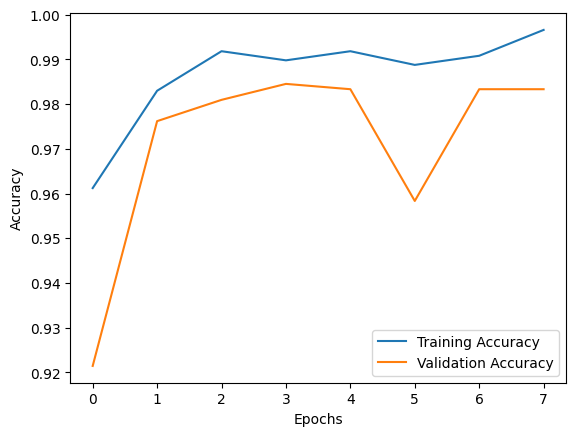

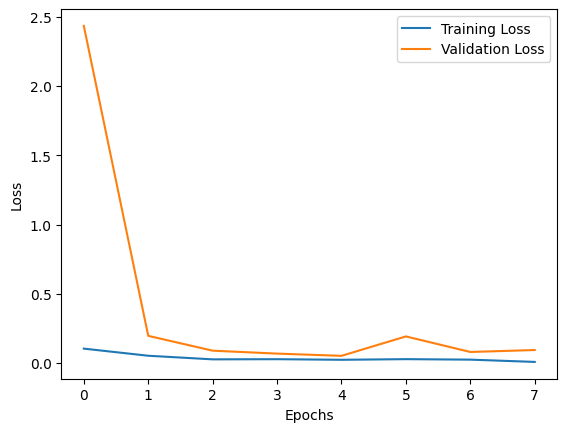

In [ ]:
# Plot training vs. validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training vs. validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

the test data using the flow_from_directory method of the test_datagen.

test_datagen = ImageDataGenerator() creates an image data generator for the test data.

test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False) sets up the test data generator. It takes the test directory path, target size, batch size, and class mode as parameters. The shuffle=False parameter ensures that the predictions are generated in the same order as the test data.

y_true = test_generator.classes retrieves the true labels for the test data. It returns an array of labels corresponding to the class indices of the test data samples.

In [ ]:
# Generate predictions for the test data
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

y_true = test_generator.classes

Found 421 images belonging to 2 classes.


14/14 [==============================] - 6s 378ms/step


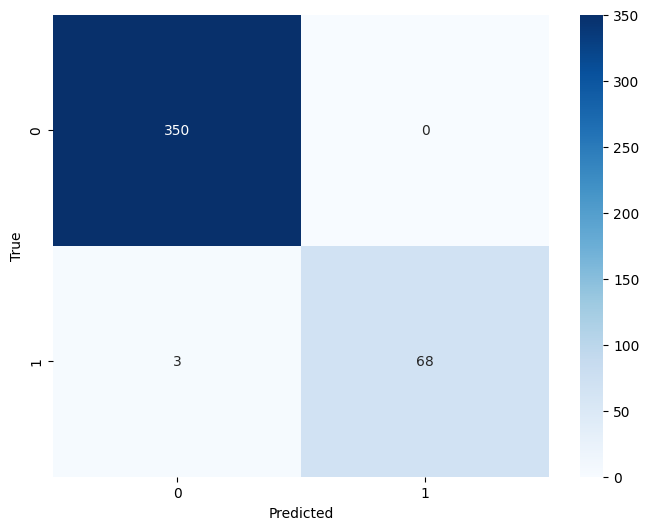

In [ ]:
y_true = test_generator.classes

# Generate predicted probabilities
y_pred = model.predict(test_generator)
y_pred_classes = np.round(y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [ ]:
# Generate classification report
target_names = ['Real', 'Fake'] 
classification_rep = classification_report(y_true, y_pred_classes, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

        Real       0.99      1.00      1.00       350
        Fake       1.00      0.96      0.98        71

    accuracy                           0.99       421
   macro avg       1.00      0.98      0.99       421
weighted avg       0.99      0.99      0.99       421

